# Short term movements in the stock market

## Data
 
The data consists of candlestick windows, where each candlestick represents one minute. There are 26 candlesticks for each window and the 21st candlestick is a "signal candle" that is either up more than 4% or down more than -4%. The windows were collected for stocks that had satisfied certain thresholds for volume, price, and (high-low)/low. For more details on the data, see the appendix.

## Goal

Find a filter criteria such that the chosen candlestick windows have a mean return as high as possible. The return for each window has been chosen to be from the open of the 22nd candlestick to the close of the 26th candlestick. The filter criteria can be either simple thresholds on features or outcome from machine learning models.

## Load data

In [1]:
import os
import pandas as pd
import numpy as np
import time

start_time = time.time()  # start timer
folder = "windows"
windows = [pd.read_csv(os.path.join(folder, f)) for f in os.listdir(folder)]
end_time = time.time()  # end timer

print(f"Number of windows: {len(windows)}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

Number of windows: 14257
Time taken: 21.95 seconds


# Clean/check data

In [2]:
# Window parameters
N_CANDLES = 26 # Candles per window
N_CANDLES_BEFORE = 20 # Candles before signal candle
N_CANDLES_AFTER = 5 # Candles after signal candle
I_SIGNAL_CANDLE = N_CANDLES_BEFORE # Index signal candle
I_BUY_CANDLE = I_SIGNAL_CANDLE + 1 # Index buy candle
I_SELL_CANDLE = I_SIGNAL_CANDLE + N_CANDLES_AFTER # Index sell candle
SIGNAL_THR = 0.04 # Threshold for absolute value of (c-o)/o for signal candle

In [3]:
# Example window
windows[0]

,v,vw,o,c,h,l,t,n
0,16771,27.7948,27.755,27.7900,27.840,27.7550,2025-02-21 15:48:00,242
1,8376,27.7565,27.780,27.7650,27.790,27.7100,2025-02-21 15:49:00,124
2,16524,27.7511,27.765,27.7500,27.780,27.7300,2025-02-21 15:50:00,221
3,17292,27.7074,27.745,27.6900,27.750,27.6850,2025-02-21 15:51:00,246
4,19804,27.6796,27.700,27.6740,27.710,27.6500,2025-02-21 15:52:00,246
5,23903,27.6273,27.665,27.5850,27.703,27.5500,2025-02-21 15:53:00,250
6,43268,27.5722,27.575,27.5750,27.603,27.5430,2025-02-21 15:54:00,471
7,30053,27.4358,27.560,27.3300,27.560,27.3300,2025-02-21 15:55:00,328
8,42423,27.2484,27.320,27.2251,27.320,27.1600,2025-02-21 15:56:00,513
9,46713,27.2400,27.235,27.2900,27.300,27.2150,2025-02-21 15:57:00,566


In [4]:
# Convert time strings to timestamp
print(f"Type before: {type(windows[0]['t'][0])}")
for w_df in windows:
    w_df['t'] = pd.to_datetime(w_df['t'], errors='coerce')
print(f"Type after: {type(windows[0]['t'][0])}")

Type before: <class 'str'>
Type after: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [5]:
# Check missing values
has_na = [w_df.isna().any().any() for w_df in windows]
windows[0].isna()
total_with_na = sum(has_na)
print(f"{total_with_na} out of {len(windows)} windows have missing values.")

0 out of 14257 windows have missing values.


In [6]:
# Check length of windows
lengths = [len(w_df) for w_df in windows]

# Find inconsistent ones
bad_length_idx = [i for i, L in enumerate(lengths) if L != N_CANDLES]
print(f"{len(bad_length_idx)} windows have incorrect length.")

0 windows have incorrect length.


In [7]:
# Check (close-open)/open for signal candle
signal_perc = [(w_df['c'][I_SIGNAL_CANDLE] - w_df['o'][I_SIGNAL_CANDLE]) / w_df['o'][I_SIGNAL_CANDLE] for w_df in windows]
signal_perc = np.abs(np.array(signal_perc))
bad_signal_idx = [i for i, perc in enumerate(signal_perc) if perc < SIGNAL_THR]

print(f"Min: {np.min(signal_perc):.3f}")
print(f"Max: {np.max(signal_perc):.3f}")


print(f"{len(bad_signal_idx)} windows have bad signal candle.")

Min: 0.040
Max: 0.619
0 windows have bad signal candle.


In [8]:
# Check if dtypes are consistent
ref_dtypes = windows[0].dtypes

inconsistent_idx = []
for i, w_df in enumerate(windows):
    if not w_df.dtypes.equals(ref_dtypes):
        inconsistent_idx.append(i)

print(f"{len(inconsistent_idx)} windows have inconsistent dtypes.")

8371 windows have inconsistent dtypes.


In [9]:
# Check first problem window
print(f"First problem window:\n{windows[inconsistent_idx[0]][:].dtypes}\n")
print(f"Reference window:\n{ref_dtypes}\n")

First problem window:
v            float64
vw           float64
o            float64
c            float64
h            float64
l            float64
t     datetime64[ns]
n              int64
dtype: object

Reference window:
v              int64
vw           float64
o            float64
c            float64
h            float64
l            float64
t     datetime64[ns]
n              int64
dtype: object



In [10]:
# Convert volume to int 
for i in inconsistent_idx:
    windows[i]['v'] = windows[i]['v'].round().astype('int64')

In [11]:
# Check inconsistent windows again
inconsistent_idx = []
for i, w_df in enumerate(windows):
    if not w_df.dtypes.equals(ref_dtypes):
        inconsistent_idx.append(i)

print(f"{len(inconsistent_idx)} windows have inconsistent dtypes.")

0 windows have inconsistent dtypes.


In [12]:
# Check chronological order for windows
not_monotonic_time = np.array([not windows[i]['t'].is_monotonic_increasing for i in range(len(windows))])
print(f"{sum(not_monotonic_time)} windows have incorrect time order")    

0 windows have incorrect time order


# Distribution of chosen features

In [13]:
import matplotlib.pyplot as plt

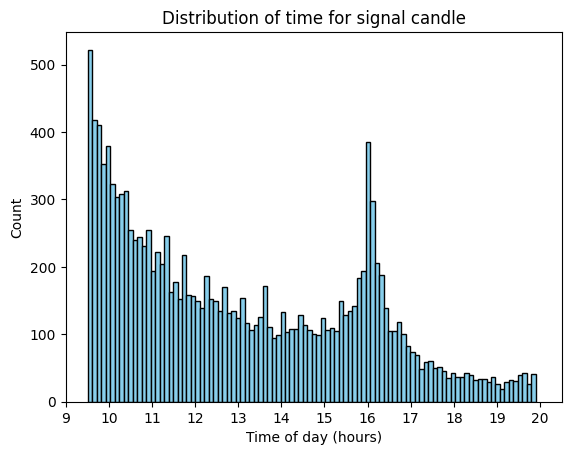

In [14]:
# Distribution of the time of day of signal candles
times_signal_h = []
for w_df in windows:
    time_signal_h = w_df['t'][I_SIGNAL_CANDLE]
    hours = time_signal_h.hour + time_signal_h.minute/60 + time_signal_h.second/3600
    times_signal_h.append(hours)


plt.hist(times_signal_h, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Time of day (hours)')
plt.ylabel('Count')
plt.title('Distribution of time for signal candle')
plt.xticks(range(8, 22, 1))
plt.xlim(9, 20.5)
plt.show()

**Figure:** Most signal candles appear near open, but there is also a peak at close. Note: The stocks from which windows were collected had to satisfy certain criteria, so the further into the days, the more stocks became qualified for window-collection. Despite this, the distribution has the form one would expect big candles to have without this type of filter.

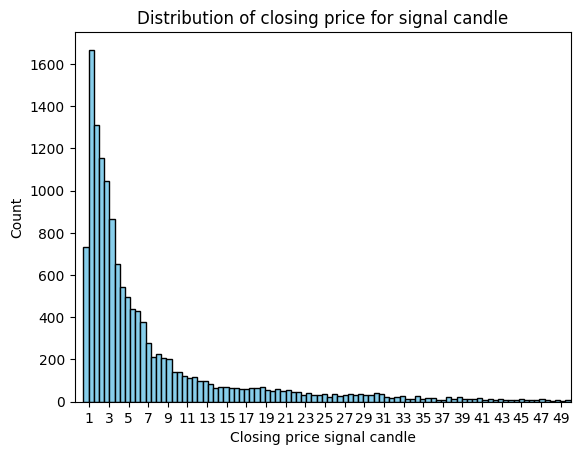

In [15]:
# Distribution of closing price for signal candle
price_signals = []
for w_df in windows:
    price_signals.append(w_df['c'][I_SIGNAL_CANDLE])
price_signals = np.array(price_signals)

plt.hist(price_signals, bins=1000, color='skyblue', edgecolor='black')
plt.xlabel('Closing price signal candle')
plt.ylabel('Count')
plt.title(f'Distribution of closing price for signal candle')
plt.xticks(range(1, 50, 2))
plt.xlim(-0.5, 50)
plt.show()

In [16]:
mean = np.mean(price_signals)   
median = np.median(price_signals) 
Min = np.min(price_signals)        
Max = np.max(price_signals)  
print(f"Summary of closing price for signal candle:")
print(f"Mean: {mean:.2f}, Median: {median:.2f}, Min: {Min:.2f}, Max: {Max:.2f}")

Summary of closing price for signal candle:
Mean: 11.12, Median: 3.85, Min: 0.41, Max: 528.00


In [17]:
# Total dollar amount last n_last candles
n_last = 5
dollar_amounts_last = []
for w_df in windows:
    dollar_amount = sum(w_df['v'][I_SIGNAL_CANDLE - n_last:I_SIGNAL_CANDLE] *\
                        (w_df['c'][I_SIGNAL_CANDLE - n_last:I_SIGNAL_CANDLE] + w_df['o'][I_SIGNAL_CANDLE - n_last:I_SIGNAL_CANDLE]) / 2)
    dollar_amounts_last.append(dollar_amount)

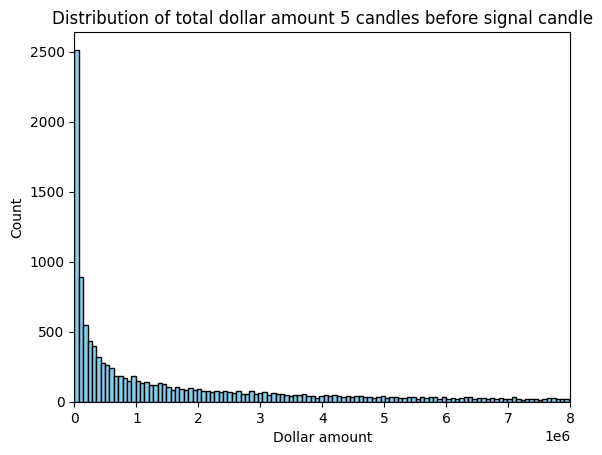

In [18]:
plt.hist(dollar_amounts_last, bins=3000, color='skyblue', edgecolor='black')
plt.xlabel('Dollar amount')
plt.ylabel('Count')
plt.title(f'Distribution of total dollar amount {n_last} candles before signal candle')
plt.xticks(range(0, 2_000_000_0, 1_000_000))
plt.xlim(-1, 8_000_000)
plt.show()

In [19]:
mean = np.mean(dollar_amounts_last)   
median = np.median(dollar_amounts_last) 
Min = np.min(dollar_amounts_last)        
Max = np.max(dollar_amounts_last) 
q01 = np.quantile(dollar_amounts_last, 0.1)  # 0.25 = 25%
print(f"Summary of total dollar amount {N_CANDLES_BEFORE} candles before signal candle:")
print(f"Mean: {mean:.0f}, Median: {median:.0f}, Min: {Min:.0f}, Max: {Max:.0f}, 0.1 quantile: {q01:.0f}")

Summary of total dollar amount 20 candles before signal candle:
Mean: 5270751, Median: 1184850, Min: 167, Max: 211629498, 0.1 quantile: 26327


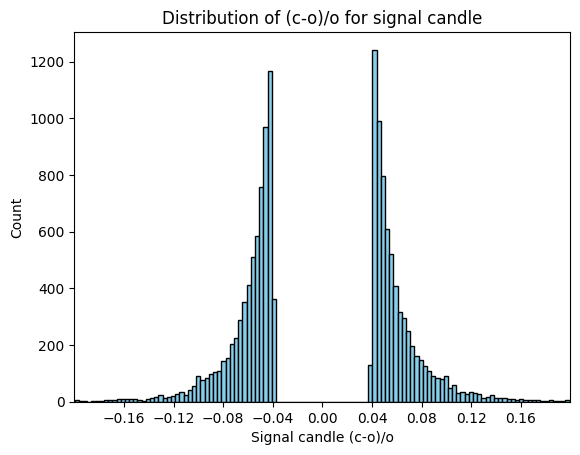

In [20]:
signal_candle_perc = []
for w_df in windows:
    signal_candle_perc.append((w_df['c'][I_SIGNAL_CANDLE] - w_df['o'][I_SIGNAL_CANDLE]) / w_df['o'][I_SIGNAL_CANDLE])
signal_candle_perc = np.array(signal_candle_perc)
plt.hist(signal_candle_perc, bins=350, color='skyblue', edgecolor='black')
plt.xlabel('Signal candle (c-o)/o')
plt.ylabel('Count')
plt.title(f'Distribution of (c-o)/o for signal candle')
plt.xticks(np.arange(-0.16, 0.16 + 0.01, 0.04))
plt.xlim(-0.2, 0.2)
plt.show()

**Figure:** We can see that the windows are consciously chosen: every signal candle satisfies $|(c-o)/o| \geq 0.04$.

In [21]:
print("Signal candle (c-o)/o summary:")
print(f"Negative candles: min: {np.min(signal_candle_perc):.3f}, max: {np.max(signal_candle_perc[signal_candle_perc < 0]):.3f}")
print(f"Positive candles: min: {np.min(signal_candle_perc[signal_candle_perc > 0]):.3f}, max: {np.max(signal_candle_perc):.3f}")

Signal candle (c-o)/o summary:
Negative candles: min: -0.619, max: -0.040
Positive candles: min: 0.040, max: 0.565


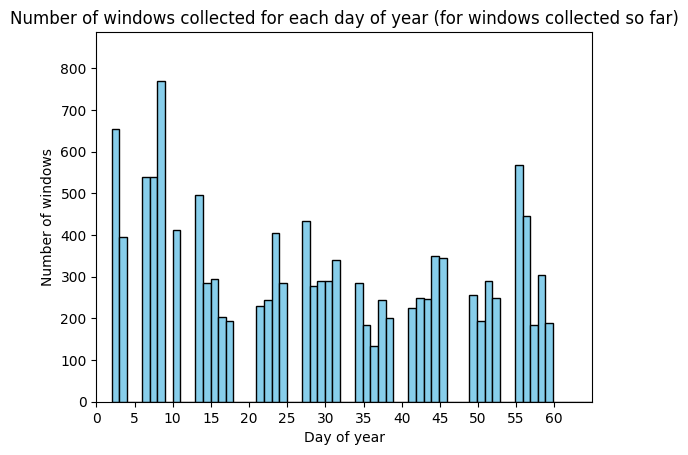

In [22]:
# Distribution of dayofyear of windows
dayofyears = []
for w_df in windows:
    dayofyears.append(w_df['t'].iloc[0].dayofyear)

plt.hist(dayofyears, bins=365, color='skyblue', edgecolor='black')
plt.xlabel('Day of year')
plt.ylabel('Number of windows')
plt.title(f'Number of windows collected for each day of year (for windows collected so far)')
plt.xticks(np.arange(0, 65, 5))
plt.xlim(0, 65)
plt.show()

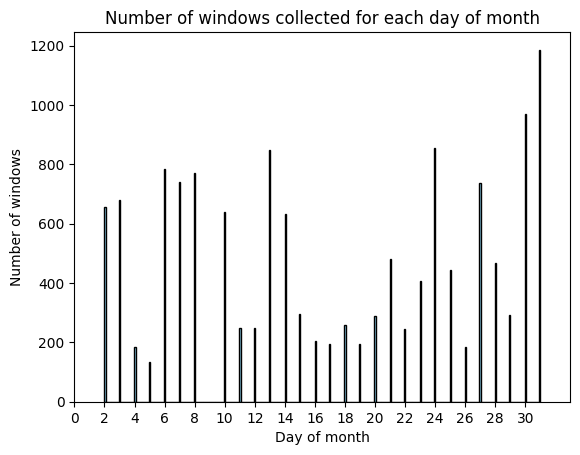

In [23]:
# Distribution of day of month of windows
dayofmonths = []
for w_df in windows:
    dayofmonths.append(w_df['t'].iloc[0].day)

plt.hist(dayofmonths, bins=365, color='skyblue', edgecolor='black')
plt.xlabel('Day of month')
plt.ylabel('Number of windows')
plt.title(f'Number of windows collected for each day of month')
plt.xticks(np.arange(0, 31, 2))
plt.xlim(0, 33)
plt.show()

# Raw features correlation with target

In [24]:
print(f"Number of rows up to and including signal candle: {len(windows[0][:I_BUY_CANDLE])}")
print(f"Number of columns: {len(windows[0].columns)}")
print(f"Number of raw features (nrows*ncols): {len(windows[0][:I_BUY_CANDLE]) * len(windows[0].dtypes)}")

Number of rows up to and including signal candle: 21
Number of columns: 8
Number of raw features (nrows*ncols): 168


In [25]:
windows[0].dtypes

v              int64
vw           float64
o            float64
c            float64
h            float64
l            float64
t     datetime64[ns]
n              int64
dtype: object

In [26]:
# Add return from open of buy candle to close of sell candle
for w_df in windows:
    w_df['rtn'] = (w_df['c'][I_SELL_CANDLE] - w_df['o'][I_BUY_CANDLE]) / w_df['o'][I_BUY_CANDLE]

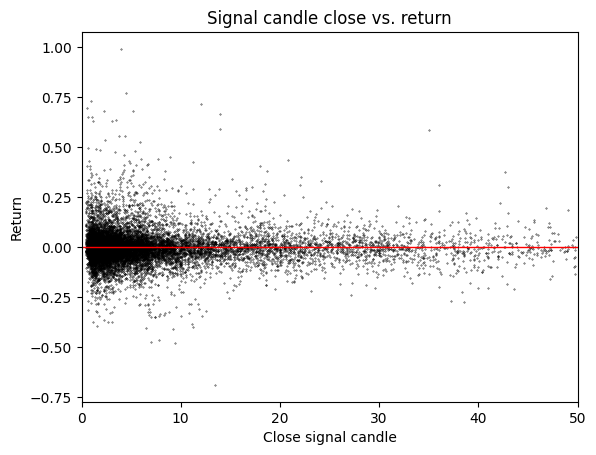

In [27]:
# Plot closing price of signal candle vs. return
returns = []
close_signals = []
for w_df in windows:
    returns.append(w_df['rtn'][0])
    close_signals.append(w_df['c'][I_SIGNAL_CANDLE])

plt.scatter(close_signals, returns, s=0.1, color='black')
plt.xlabel("Close signal candle")
plt.ylabel("Return")
plt.title("Signal candle close vs. return")
plt.hlines(0, 0, 400, color='red', lw=1)
plt.xlim(0, 50)
plt.show()

**Figure:** Just a first look to see how noisy the return is.

In [28]:
# Derive time features from 't'
for w_df in windows:
    w_df['minute'] = w_df['t'].dt.minute
    w_df['hour'] = w_df['t'].dt.hour
    w_df['dayofweek'] = w_df['t'].dt.dayofweek
    w_df['dayofmonth'] = w_df['t'].dt.day
    w_df['dayofyear'] = w_df['t'].dt.dayofyear
    w_df['month'] = w_df['t'].dt.month

print(f"Added time features (using windows[0].iloc[0]) as example):"
      f"\nminute: {windows[0]['minute'].iloc[0]}\nhour: {windows[0]['hour'].iloc[0]}"
      f"\ndayofweek: {windows[0]['dayofweek'].iloc[0]}\ndayofmonth: {windows[0]['dayofmonth'].iloc[0]}"
      f"\ndayofyear: {windows[0]['dayofyear'].iloc[0]}\nmonth: {windows[0]['month'].iloc[0]}")

Added time features (using windows[0].iloc[0]) as example):
minute: 48
hour: 15
dayofweek: 4
dayofmonth: 21
dayofyear: 52
month: 2


In [29]:
windows[0]

,v,vw,o,c,h,l,t,n,rtn,minute,hour,dayofweek,dayofmonth,dayofyear,month
0,16771,27.7948,27.755,27.7900,27.840,27.7550,2025-02-21 15:48:00,242,-0.009385,48,15,4,21,52,2
1,8376,27.7565,27.780,27.7650,27.790,27.7100,2025-02-21 15:49:00,124,-0.009385,49,15,4,21,52,2
2,16524,27.7511,27.765,27.7500,27.780,27.7300,2025-02-21 15:50:00,221,-0.009385,50,15,4,21,52,2
3,17292,27.7074,27.745,27.6900,27.750,27.6850,2025-02-21 15:51:00,246,-0.009385,51,15,4,21,52,2
4,19804,27.6796,27.700,27.6740,27.710,27.6500,2025-02-21 15:52:00,246,-0.009385,52,15,4,21,52,2
5,23903,27.6273,27.665,27.5850,27.703,27.5500,2025-02-21 15:53:00,250,-0.009385,53,15,4,21,52,2
6,43268,27.5722,27.575,27.5750,27.603,27.5430,2025-02-21 15:54:00,471,-0.009385,54,15,4,21,52,2
7,30053,27.4358,27.560,27.3300,27.560,27.3300,2025-02-21 15:55:00,328,-0.009385,55,15,4,21,52,2
8,42423,27.2484,27.320,27.2251,27.320,27.1600,2025-02-21 15:56:00,513,-0.009385,56,15,4,21,52,2
9,46713,27.2400,27.235,27.2900,27.300,27.2150,2025-02-21 15:57:00,566,-0.009385,57,15,4,21,52,2


**Note:** Minute difference between rows doesn't have to be 1: candles with no volume are not included.

In [30]:
# Flatten windows
all_rows = []
skip_cols = ['rtn', 't', 'dayofweek', 'dayofmonth', 'dayofyear', 'month'] 

for w_df in windows:
    flattened = w_df.iloc[:I_BUY_CANDLE].drop(columns=skip_cols, errors='ignore').values.flatten(order='F')

    # variables that are constant in the windows
    rtn_value = w_df['rtn'].iloc[0]
    dayofweek = w_df['dayofweek'].iloc[0]
    dayofmonth = w_df['dayofmonth'][0]
    dayofyear = w_df['dayofyear'].iloc[0]
    month = w_df['month'].iloc[0]
    
    row = np.array([rtn_value] + list(flattened) + [dayofweek, dayofmonth, dayofyear, month]) # flattened window

    all_rows.append(row)

n_full_cols = flattened.shape[0] # Number of columns for which all rows are used
assert n_full_cols % (N_CANDLES_BEFORE + 1) == 0

df_flattened_windows = pd.DataFrame(all_rows)  # directly from the list of lists

print(df_flattened_windows.shape)  # should be (14000, N_CANDLES_BEFORE * num_features + 1)
print(f"Features per window: {df_flattened_windows.shape[1]}")
print(f"{n_full_cols} features are from window columns for which all rows were used")

(14257, 194)
Features per window: 194
189 features are from window columns for which all rows were used


In [31]:
# Feature dictionary

headers_full_cols = ['v', 'vw', 'o', 'c', 'h', 'l', 'n', 'minute', 'hour']
feature_dict = {}

# First column
feature_dict[0] = 'rtn'

# Columns with whose all rows are used
for i in range(1, n_full_cols + 1):  
    if (i - 1) % (N_CANDLES_BEFORE + 1) == 0:
        # change header
        header = headers_full_cols[i // (N_CANDLES_BEFORE + 1)]
    candle = (i - 1) % (N_CANDLES_BEFORE + 1)
    feature_dict[i] = f"{header}, candle {candle}"

# Columns with only one value
for i in range(len(skip_cols) - 2): # 'rtn' already first col, 't' is splitted to other time features
    feature_dict[i + n_full_cols + 1] = f"{skip_cols[i+2]}"

In [32]:
# Pearson correlation for all columns w.r.t first column (target)
print("Pearson correlation, features vs target:\n")
correlations = df_flattened_windows.corr()[0] 
for i, corr in enumerate(correlations):
    print(f"Column {i} ({feature_dict[i]}) vs target: {corr:.4f}")

Pearson correlation, features vs target:

Column 0 (rtn) vs target: 1.0000
Column 1 (v, candle 0) vs target: 0.0033
Column 2 (v, candle 1) vs target: -0.0003
Column 3 (v, candle 2) vs target: -0.0030
Column 4 (v, candle 3) vs target: -0.0033
Column 5 (v, candle 4) vs target: -0.0064
Column 6 (v, candle 5) vs target: -0.0052
Column 7 (v, candle 6) vs target: -0.0026
Column 8 (v, candle 7) vs target: -0.0026
Column 9 (v, candle 8) vs target: -0.0049
Column 10 (v, candle 9) vs target: 0.0023
Column 11 (v, candle 10) vs target: 0.0084
Column 12 (v, candle 11) vs target: 0.0057
Column 13 (v, candle 12) vs target: 0.0028
Column 14 (v, candle 13) vs target: 0.0114
Column 15 (v, candle 14) vs target: 0.0096
Column 16 (v, candle 15) vs target: 0.0022
Column 17 (v, candle 16) vs target: 0.0102
Column 18 (v, candle 17) vs target: 0.0099
Column 19 (v, candle 18) vs target: 0.0071
Column 20 (v, candle 19) vs target: 0.0110
Column 21 (v, candle 20) vs target: 0.0204
Column 22 (vw, candle 0) vs targe

In [33]:
top10 = correlations.abs().sort_values(ascending=False).head(10)
top10_corr = correlations[top10.index]

print("Top 10 correlations:\n")
for i in range(len(top10)):
    print(f"Column {top10.index[i]} ({feature_dict[top10.index[i]]}), {top10_corr.iloc[i]:.4f}")

Top 10 correlations:

Column 0 (rtn), 1.0000
Column 21 (v, candle 20), 0.0204
Column 133 (n, candle 6), -0.0196
Column 191 (dayofmonth), -0.0194
Column 151 (minute, candle 3), -0.0173
Column 131 (n, candle 4), -0.0169
Column 153 (minute, candle 5), -0.0161
Column 150 (minute, candle 2), -0.0159
Column 149 (minute, candle 1), -0.0153
Column 152 (minute, candle 4), -0.0149


Volume of candle 20 and dayofmonth probably reasonable to be on the list. Number of trades at candle 4 and 6, and the minute of candles 1, 2, 3, 4, 5 seem strange at a first glance.

"The return for windows whose first 1-5 candles have higher "minute" (further into the hour) is smaller".

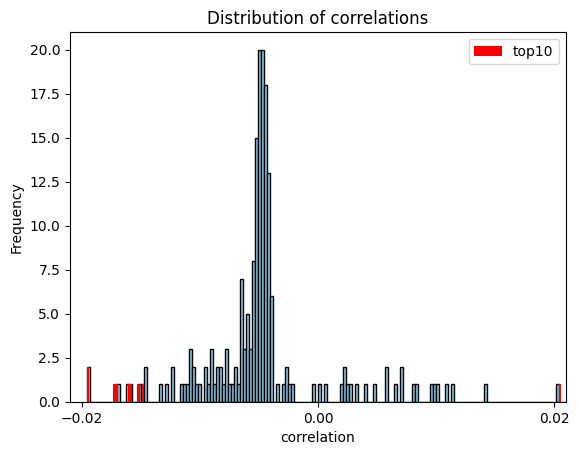

In [34]:
# Histogram of correlations
plt.hist(correlations, bins=4000, color='skyblue', edgecolor='black')
plt.hist(top10_corr, bins=5000, color='red', label="top10")
plt.xlabel('correlation')
plt.ylabel('Frequency')
plt.title(f'Distribution of correlations')
plt.xticks(np.arange(-0.5, 0.5, 0.02))
plt.xlim(-0.021, 0.021)
plt.legend()
plt.show()

# Baseline return

In [35]:
# Baseline return
returns = []
for w in windows:
    rtn = (w['c'].iloc[I_SELL_CANDLE] - w['o'].iloc[I_BUY_CANDLE]) / w['o'].iloc[I_BUY_CANDLE]
    returns.append(rtn)
returns = np.array(returns)
baseline = np.mean(returns)
print(f"Mean baseline return (using only initial filter): {baseline:.4f}")

Mean baseline return (using only initial filter): 0.0011


## todo:

Screen with Spearman correlation

Screen with depth 1-decision tree

Screen with depth 2-decision tree

Engineer features, e.g.,

- Slope of lin.reg on price last n candles

- Slope of lin.reg on vol last n candles

- Fractional distance from vwap to close of signal candle

- Relative volume last n candles compared to m candles earlier

- Dollar amount last n candles

- Fractional distance from close of signal candle to low of last n candles (if signal < 0) or to high of last 20 candles (if signal > 0)

Check correlation between engineered features and target

Try different models

# Appendix

The process of collecting candlestick windows was as follows:

1. Daily OHLCV data were downloaded for all U.S. stocks over a one-year period, resulting in approximately 2,000,000 daily summaries.
2. The daily summaries were filtered using the following filter criteria:
- $\text{volume} > 600,000$
- $\text{high} > 1$
- $(\text{high} - \text{low}) / \text{low} > 0.1$


3. For each filtered (stock, day) combination, 1-minute data was downloaded.
4. For the 1-minute data, for each (stock, day) combination, candlesticks with $(\text{close} - \text{open}) / \text{open} \geq 0.04$ or $\leq -0.04$ were identified for every point after the given (stock, day) had satisfied the filter criteria above. For example, if a given (stock, day) had satisfied $\text{volume} > 600000$, $\text{high} > 1$, and $(\text{high} - \text{low}) / \text{low} > 0.1$ at 09:55, candlesticks with $\geq 0.04$ or $\leq-0.04$ were identified for every point from 09:55 and onward (until close of post market).
5. For each such found candlestick, the candlestick itself, 20 candlesticks before, and 5 candlesticks after were aggregated into a window of 26 candlesticks.

**Note:** The point at which the volume and the two other thresholds for the 1-minute data started to be checked was at 09:30. The reason for this was that some of the daily summaries only were for regular hours, and it is not possible to check whether daily criteria are fulfilled during pre-market: a stock satisfying the criteria during pre-market may not do so during regular hours. Hence we would never know if a stock encountered during pre-market actually is the type of stock the model was trained on.